In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats
from IPython.display import Image
import plotly.io as pio

from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix

import os
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (12, 7)
pd.set_option('display.max_columns', None)

sns.set_style("darkgrid")
%matplotlib inline

In [ ]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler
from plots import Plots
file_handler = FileHandler()
plot = Plots()

import warnings
warnings.filterwarnings('ignore')

In [80]:
train_df = file_handler.read_csv("../data/cleaned_train.csv")
test_df = file_handler.read_csv("../data/cleaned_test.csv")
store_df = file_handler.read_csv("../data/cleaned_store.csv") 

2022-05-26 17:01:52,166 — FileHandler — DEBUG — file read as csv
2022-05-26 17:01:52,198 — FileHandler — DEBUG — file read as csv
2022-05-26 17:01:52,203 — FileHandler — DEBUG — file read as csv


#### Data Field Description
- `Id` - an Id that represents a(Store, Date) duple within the test set
- `Store` - a unique Id for each store
- `Sales` - the turnover for any given day(this is what you are predicting)
- `Customers` - the number of customers on a given day
- `Open` - an indicator for whether the store was open: 0 = closed, 1 = open
- `StateHoliday` - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- `SchoolHoliday` - indicates if the(Store, Date) was affected by the closure of public schools
- `StoreType` - differentiates between 4 different store models: a, b, c, d
- `Assortment` - describes an assortment level: a = basic, b = extra, c = extended. Read more about assortment here
- `CompetitionDistance` - distance in meters to the nearest competitor store
- `CompetitionOpenSince[Month / Year]` - gives the approximate year and month of the time the nearest competitor was opened
- `Promo` - indicates whether a store is running a promo on that day
- `Promo2` - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- `Promo2Since[Year / Week]` - describes the year and calendar week when the store started participating in Promo2
- `PromoInterval` - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [ ]:
stores_types = ["A", "B", "C", "D"]
state_holidays = [ "Normal Day", "Public holiday", "Easter holiday", "Christmas"] 
school_holidays = ["School is closed", "School is open"]
assortment = [ "Basic", "Extra", "Extended"] 
promo = ["Not participating", "Participating"]
store_open = ["Closed", "Open"]

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  int64 
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 69.8+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             41088 non-null  int64 
 1   Store          41088 non-null  int64 
 2   DayOfWeek      41088 non-null  int64 
 3   Date           41088 non-null  object
 4   Open           41088 non-null  int64 
 5   Promo          41088 non-null  int64 
 6   StateHoliday   41088 non-null  int64 
 7   SchoolHoliday  41088 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 2.5+ MB


In [ ]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1485,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Store                      1115 non-null   int64
 1   StoreType                  1115 non-null   int64
 2   Assortment                 1115 non-null   int64
 3   CompetitionDistance        1115 non-null   int64
 4   CompetitionOpenSinceMonth  1115 non-null   int64
 5   CompetitionOpenSinceYear   1115 non-null   int64
 6   Promo2                     1115 non-null   int64
 7   Promo2SinceWeek            1115 non-null   int64
 8   Promo2SinceYear            1115 non-null   int64
 9   PromoInterval              1115 non-null   int64
dtypes: int64(10)
memory usage: 87.2 KB


In [ ]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Store                      1115 non-null   int64
 1   StoreType                  1115 non-null   int64
 2   Assortment                 1115 non-null   int64
 3   CompetitionDistance        1115 non-null   int64
 4   CompetitionOpenSinceMonth  1115 non-null   int64
 5   CompetitionOpenSinceYear   1115 non-null   int64
 6   Promo2                     1115 non-null   int64
 7   Promo2SinceWeek            1115 non-null   int64
 8   Promo2SinceYear            1115 non-null   int64
 9   PromoInterval              1115 non-null   int64
dtypes: int64(10)
memory usage: 87.2 KB


In [ ]:
train_df.shape, test_df.shape, store_df.shape

((1017209, 9), (41088, 8), (1115, 10))

Merge store dataframe to train and test dataframes

In [81]:
train_df = pd.merge(train_df, store_df, how = 'left', on = 'Store')
test_df = pd.merge(test_df, store_df, how = 'left', on = 'Store')

In [82]:
# The types and shape of data features in the dataset

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype 
---  ------                     --------------    ----- 
 0   Store                      1017209 non-null  int64 
 1   DayOfWeek                  1017209 non-null  int64 
 2   Date                       1017209 non-null  object
 3   Sales                      1017209 non-null  int64 
 4   Customers                  1017209 non-null  int64 
 5   Open                       1017209 non-null  int64 
 6   Promo                      1017209 non-null  int64 
 7   StateHoliday               1017209 non-null  int64 
 8   SchoolHoliday              1017209 non-null  int64 
 9   StoreType                  1017209 non-null  int64 
 10  Assortment                 1017209 non-null  int64 
 11  CompetitionDistance        1017209 non-null  int64 
 12  CompetitionOpenSinceMonth  1017209 non-null  int64 
 13  CompetitionOpenSinceYear   

In [83]:
# The types and shape of data features in the dataset

test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Id                         41088 non-null  int64 
 1   Store                      41088 non-null  int64 
 2   DayOfWeek                  41088 non-null  int64 
 3   Date                       41088 non-null  object
 4   Open                       41088 non-null  int64 
 5   Promo                      41088 non-null  int64 
 6   StateHoliday               41088 non-null  int64 
 7   SchoolHoliday              41088 non-null  int64 
 8   StoreType                  41088 non-null  int64 
 9   Assortment                 41088 non-null  int64 
 10  CompetitionDistance        41088 non-null  int64 
 11  CompetitionOpenSinceMonth  41088 non-null  int64 
 12  CompetitionOpenSinceYear   41088 non-null  int64 
 13  Promo2                     41088 non-null  int64 
 14  Promo2

Remove Id column from test dataframe

In [ ]:
ID = test_df['Id']
test_df.drop('Id',inplace=True,axis=1)

In [ ]:
test_df.describe()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000,41088.000
mean,555.900,3.979,0.854,0.396,0.004,0.443,1.252,1.001,4456.861,4.800,2001.738,0.581,14.182,2001.738,0.932
std,320.274,2.015,0.353,0.489,0.066,0.497,1.397,0.995,4910.183,3.836,10.521,0.493,16.178,10.521,0.989
min,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,20.000,1.000,1900.000,0.000,0.000,1900.000,0.000
25%,279.750,2.000,1.000,0.000,0.000,0.000,0.000,0.000,720.000,1.000,1990.000,0.000,0.000,1990.000,0.000
50%,553.500,4.000,1.000,0.000,0.000,0.000,0.000,1.000,2410.000,4.000,2005.000,1.000,9.000,2005.000,1.000
75%,832.250,6.000,1.000,1.000,0.000,1.000,3.000,2.000,6435.000,9.000,2011.000,1.000,31.000,2011.000,1.000
max,1115.000,7.000,1.000,1.000,1.000,1.000,3.000,2.000,16107.000,12.000,2015.000,1.000,49.000,2015.000,3.000


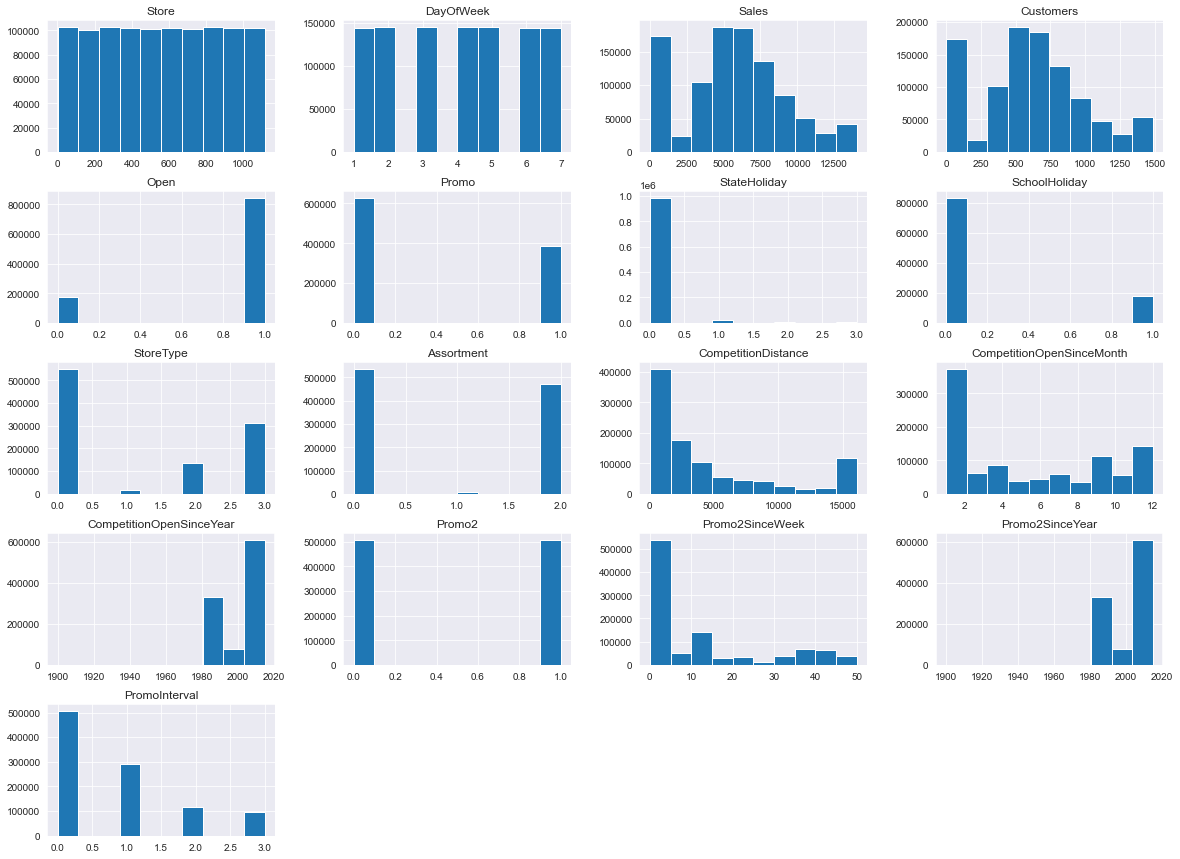

In [ ]:
# Numerical Features Histograms (Train)
num_feats = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[num_feats].hist(figsize=(20,15));

array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'DayOfWeek'}>,
        <AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'Promo'}>],
       [<AxesSubplot:title={'center':'StateHoliday'}>,
        <AxesSubplot:title={'center':'SchoolHoliday'}>,
        <AxesSubplot:title={'center':'StoreType'}>,
        <AxesSubplot:title={'center':'Assortment'}>],
       [<AxesSubplot:title={'center':'CompetitionDistance'}>,
        <AxesSubplot:title={'center':'CompetitionOpenSinceMonth'}>,
        <AxesSubplot:title={'center':'CompetitionOpenSinceYear'}>,
        <AxesSubplot:title={'center':'Promo2'}>],
       [<AxesSubplot:title={'center':'Promo2SinceWeek'}>,
        <AxesSubplot:title={'center':'Promo2SinceYear'}>,
        <AxesSubplot:title={'center':'PromoInterval'}>, <AxesSubplot:>]],
      dtype=object)

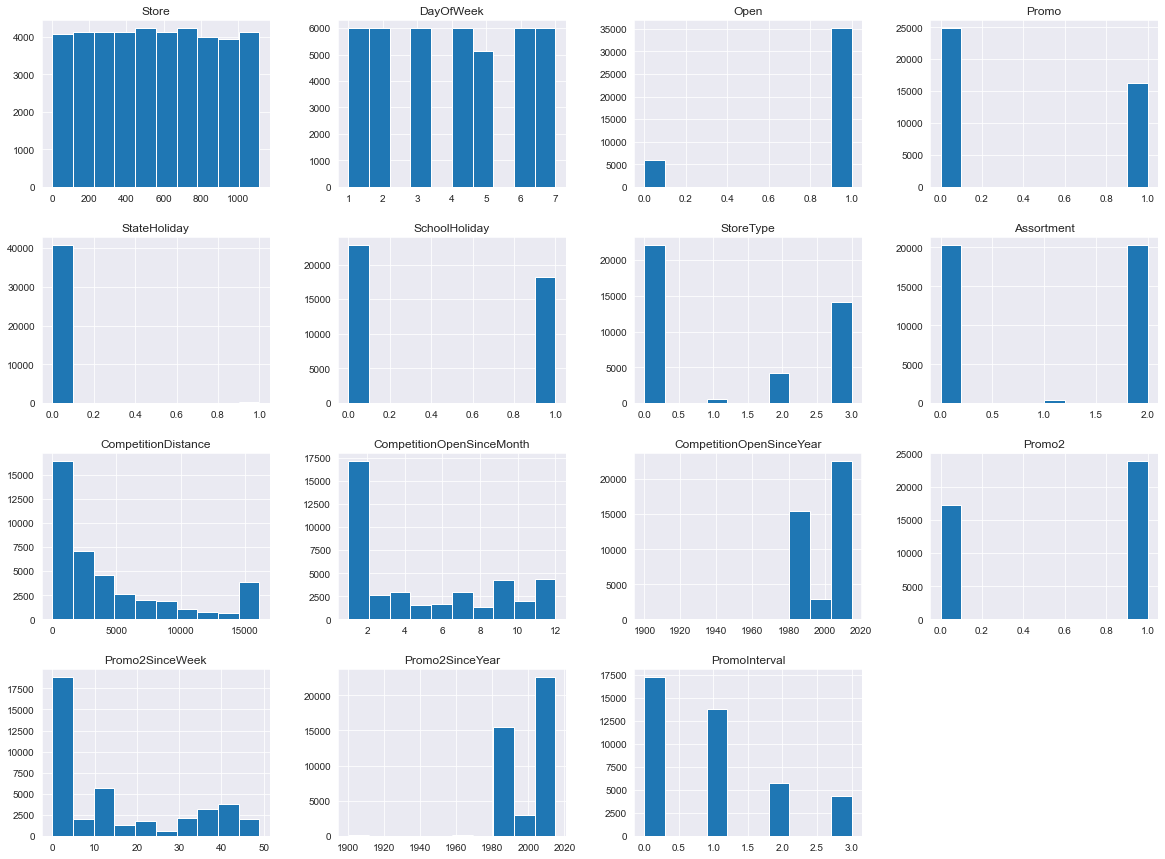

In [ ]:
# Numerical Features Histograms (Test)
num_feats = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_df[num_feats].hist(figsize=(20,15))

- Most of the training and testing columns have proportional data distribution except `School Holiday`, where we have more school holidays [1's] in test data than training data
- Most of the stores prefer to make promotions in Jan, Apr, Jul, and Oct (at number 1.0, 4.0, 9.0, and 10.0) Promo intervals. 
- Almost all stores are closed on Sunday (at number 7)


#

#### Compare Training and Testing Groups

##### Are the promotions distributed similarly between Training and Testing groups?

In [ ]:
train_data = train_df.copy()
test_data = test_df.copy()

def compare_test_train(train_data, test_data, feature, title):
    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
    ax[0].set_title("Train " + title)
    sns.countplot(x=feature, data=train_data, ax=ax[0])
    ax[1].set_title("Test " + title)
    sns.countplot(x=feature, data=test_data, ax=ax[1])
    fig.subplots_adjust(wspace=0.3)
    # fig.show()

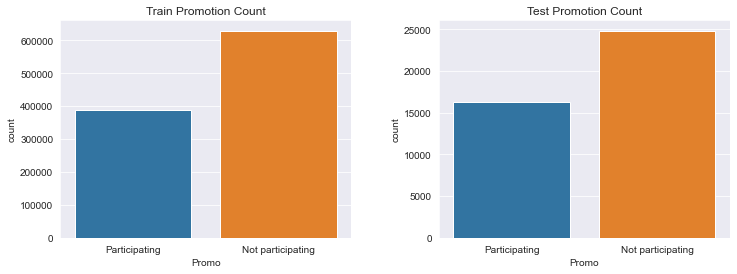

In [ ]:
train_data["Promo"] = train_data["Promo"].apply(lambda x: promo[x])
test_data["Promo"] = test_data["Promo"].apply(lambda x: promo[x])
compare_test_train(train_data, test_data, 'Promo', 'Promotion Count')

As we see the promotions are evenly distributed between Training and Testing datasets.

##### Check & compare the proportion of holidays in training and testing dataset

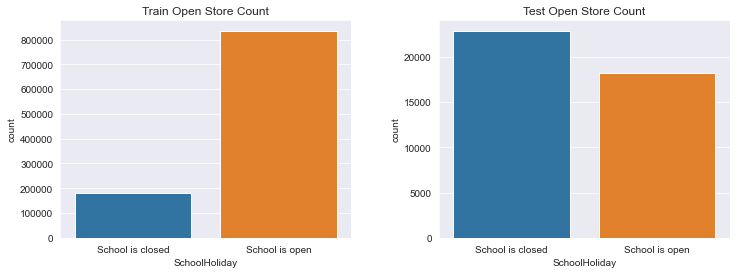

In [ ]:
train_data["SchoolHoliday"] = train_data["SchoolHoliday"].apply(lambda x: school_holidays[x])
test_data["SchoolHoliday"] = test_data["SchoolHoliday"].apply(lambda x: school_holidays[x])
compare_test_train(train_data, test_data, 'SchoolHoliday', "Open Store Count")

In the case of School Holiday the testing datasets unexpectedly have more number of school closings than school openings.

In [ ]:
def compare_test_train_holiday(data, col, agg_fun):
    value_list = data.groupby([col]).agg({col: [agg_fun]})
    value_list.columns = [agg_fun]
    value_list = value_list.reset_index()
    value_list[col] = value_list[col].apply(lambda x: state_holidays[x])
    return value_list

In [ ]:
compare_test_train_holiday(train_data, 'StateHoliday', 'count')

,StateHoliday,count
0,Normal Day,986159
1,Public holiday,20260
2,Easter holiday,6690
3,Christmas,4100


In [ ]:
compare_test_train_holiday(test_data, 'StateHoliday', 'count')

,StateHoliday,count
0,Normal Day,40908
1,Public holiday,180


The proportion of normal days to public holidays in the case of training data is 2.05%. This means for every 100 normal days we will have 2 public holidays. Whereas in the case of testing data, the proportion is 0.44, which is for 1000 normal days 4 public holidays. In addition to this,  the type of SateHolidays in testing data does not include Easter and Christmas.

##### Seasonality in Purchasing

In [ ]:
train_data["StoreType"] = train_data["StoreType"].apply(lambda x: stores_types[x])
store_type_df = train_data.groupby('StoreType').agg({'Customers': 'mean', 'Sales': 'mean'})
store_type_df = store_type_df.reset_index()
store_type_df

,StoreType,Customers,Sales
0,A,640.026,5640.539
1,B,1321.560,9198.316
2,C,663.820,5668.122
3,D,501.293,5611.875


Stores Type `B` looks like having a greater number of customers and with respect to that a greater mean sales than the others. 

##### What can you say about the correlation between sales and number of customers?

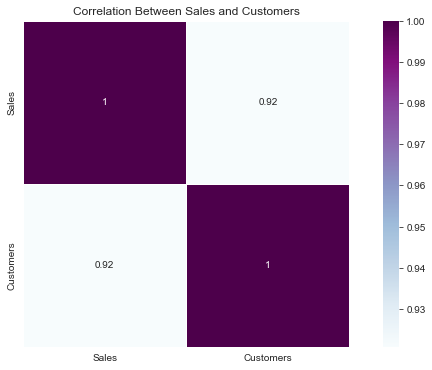

In [ ]:
plot.heatmap(train_data[['Sales', 'Customers']], title='Correlation Between Sales and Customers')

There is a high correlation between Sales and Customers. The more customers the more sales as expected.

##### How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?

<AxesSubplot:>

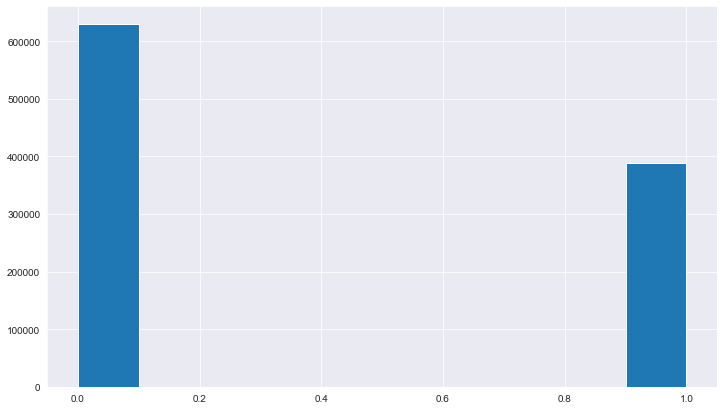

In [ ]:
train_df['Promo'].hist(figsize=(12,7))

In [ ]:
def evaluate_promotion(data, col1, col2, col3, agg_fun): 
    value_list = data.groupby(col1).agg({col2: agg_fun, col3: agg_fun}) 
    value_list = value_list.reset_index()
    return value_list

In [ ]:
evaluate_promotion(train_data, 'Promo', 'Customers', 'Sales', 'mean')

,Promo,Customers,Sales
0,Not participating,500.442,4367.533
1,Participating,790.638,7835.989


In [ ]:
def to_month_category(value):
    try:
        
        if (value >= 1 and int(value) < 10):
            return "BegMonth"

        elif (value >= 10 and value < 20):
            return "MidMonth"
        else:
            return "EndMonth"
    except:
        pass

def transform_date(df):
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = pd.DatetimeIndex(df['Date']).year
    df['Month'] = pd.DatetimeIndex(df['Date']).month
    df['Day'] = pd.DatetimeIndex(df['Date']).day
    df['DayInMonth'] = df['Day'].apply(lambda x: to_month_category(x))
    return df

In [ ]:
df = transform_date(train_data.copy())

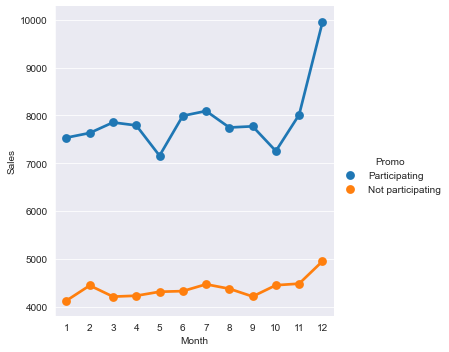

In [ ]:
sns.factorplot(data = df, x ="Month", y = "Sales",
               hue = 'Promo',
              sharex=False)

<Figure size 864x504 with 0 Axes>

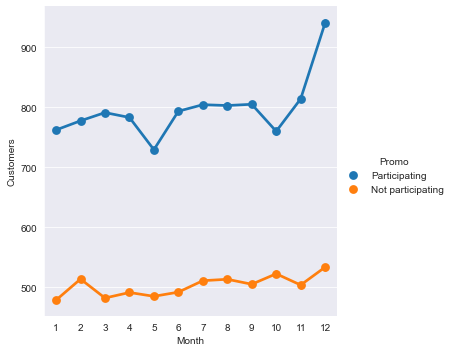

In [34]:
plt.figure(figsize=(12,7))
sns.factorplot(data = df, x ="Month", y = "Customers", hue = 'Promo', sharex=False)

As you see, the promotions have result in an increase in the number of Customers and Sales as expected. About 79.4% Sales lift is generated due to promotions.


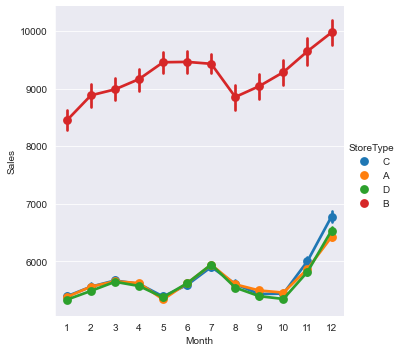

In [35]:
sns.factorplot(data = df, x ="Month", y = "Sales", hue = 'StoreType')

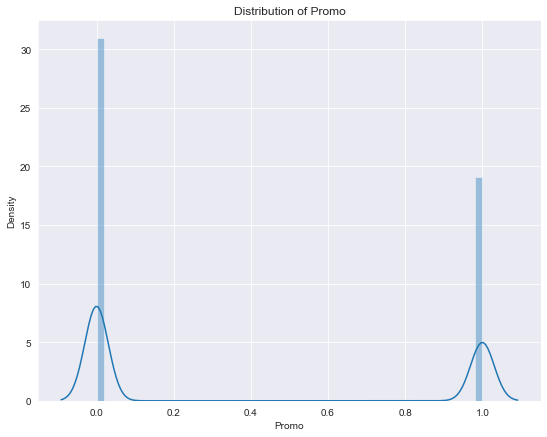

In [36]:
plt.figure(figsize=(9, 7))
sns.distplot(train_df['Promo']).set_title(f'Distribution of Promo')
plt.show()

##### Could the promos be deployed in more effective ways? Which stores should promos be deployed in?

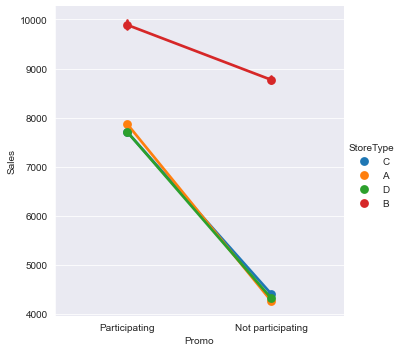

In [37]:

sns.factorplot(data = df, x ="Promo", y = "Sales", hue = 'StoreType')

For the maximum Sales achievement one of the reason can be the promotion. Store B, which have the maximum number of Customers and Sales record is by far the higher promoting store. Therefore, other stores should be as promoting as Store B for better success. 

##### Average daily Sales of the Store types

In [38]:
def plot_trend(df, columns, feature, title, x_label="", y_label="", labels=['']):
  plt.figure(figsize=(18, 6))
  for i in range(len(columns)):
    sns.lineplot(x=df.index, y=df[columns[i]][feature], label=labels[i])
  plt.title(title, fontsize=15, fontweight='bold')
  plt.ylabel(x_label, fontsize=14)
  plt.xlabel(y_label, fontsize=14)
  plt.show()

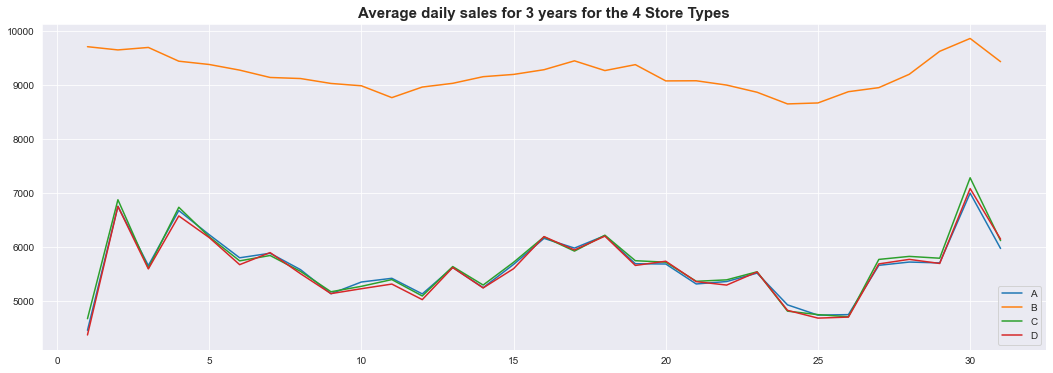

In [39]:

daily_trend = df.groupby(['Day', 'StoreType']).agg({'Customers': 'mean', 'Sales': 'mean'})
daily_trend = daily_trend.unstack().swaplevel(0, 1, 1).sort_index(1)
columns = ["A", "B", "C", "D"]
plot_trend(daily_trend, columns, 'Sales', 'Average daily sales for 3 years for the 4 Store Types', labels=columns)

##### Trends of customer behavior during Store Open and Closing times

In [40]:
cust_trend = df.groupby(['Open']).agg({'Customers': 'count', 'Sales': 'mean'})
cust_trend.columns = ['Customers',	'Sales']
cust_trend

,Customers,Sales
Open,,
0,172817,0.000
1,844392,6855.503


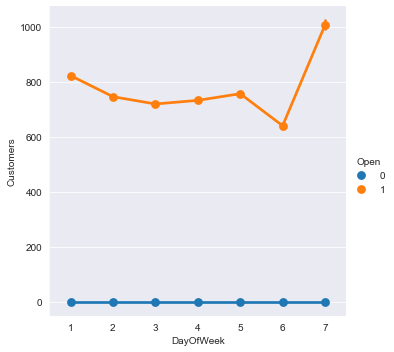

In [41]:
sns.factorplot(data = df, x ="DayOfWeek", y = "Customers", hue = 'Open', sharex=False)

The number of customers during Stores open is smaller and obviously higher number of Customers is recorded on Opened times.

##### Trends of customer behavior during days of the weeks

In [42]:
weekly_data = df.groupby(['DayOfWeek']).agg({'DayOfWeek': 'count', 'Customers': 'mean', 'Sales': 'mean'})
weekly_data.columns = ['Count', 'Customers', 'Sales']
weekly_data

,Count,Customers,Sales
DayOfWeek,,,
1,144730,781.505,7599.141
2,145664,736.728,6907.136
3,145665,700.534,6490.330
4,145845,675.857,6185.286
5,145845,718.934,6651.851
6,144730,636.840,5794.267
7,144730,24.977,183.356


##### Which stores are opened on all weekdays? How does that affect their sales on weekends?

Stores That work all Week are : 33


<Figure size 864x504 with 0 Axes>

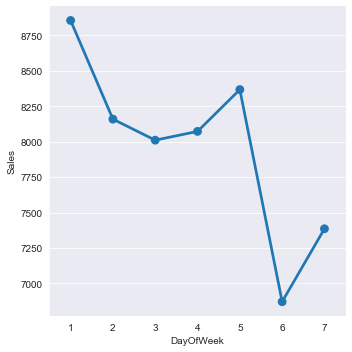

In [43]:
# stores, where their unique DayOfWeek count to 7
open_stores = df[df.Open == 1]
each_day = open_stores[['Store', 'DayOfWeek']].groupby('Store').nunique()

all_week_stores = each_day[each_day.DayOfWeek == 7]
stores_id = all_week_stores.reset_index()['Store']

get_stores = open_stores[(open_stores.Store.isin(set(stores_id)))]
get_stores = get_stores[['Store', 'Sales', 'Customers', 'DayOfWeek']]

week_sales = get_stores.groupby('DayOfWeek').mean().reset_index()

plt.figure(figsize=(12,7))
sns.factorplot(data = week_sales, x ="DayOfWeek", y = "Sales",
              sharex=False)
print(f'Stores That work all Week are : {all_week_stores.shape[0]}')

33 Stores works all weeks along and their Sales amount rises on the weekends, i.e, when DayOfWeek = 6 & 7

##### Check how the assortment type affects sales

Text(0.5, 1.0, 'Assortment Vs Customers ')

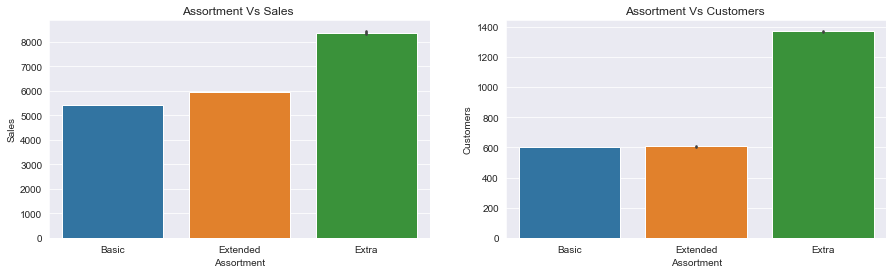

In [44]:
df["Assortment"] = df["Assortment"].apply(lambda x: assortment[x])

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Assortment', y='Sales', data=df, ax=axis1)
sns.barplot(x='Assortment', y='Customers', data=df, ax=axis2)
axis1.set_title("Assortment Vs Sales " )
axis2.set_title("Assortment Vs Customers ")

Stores with extra assortment have highest mean Sales and number of Customers

##### How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?


In [45]:
df_competition = df.groupby("Store").agg({ "Sales": "sum", 
                                           "Customers": "sum",
                                           "CompetitionDistance": "mean"
                                           })
df_competition.head(10)

,Sales,Customers,CompetitionDistance
Store,,,
1,3716854,440523,1270.000
2,3883858,457855,570.000
3,5405105,584216,14130.000
4,7523256,1014958,620.000
5,3642818,418588,16107.000
6,4297758,495483,310.000
7,6898710,745101,16107.000
8,4342857,516027,7520.000
9,5112061,451677,2030.000


In [46]:
df_competition.tail(10)

,Sales,Customers,CompetitionDistance
Store,,,
1106,3836971,437169,5330.000
1107,3877991,416495,1400.000
1108,4481290,460408,540.000
1109,3064721,281354,3490.000
1110,3548486,422958,900.000
1111,4091076,351883,1900.000
1112,7694122,652807,1880.000
1113,5194013,561801,9260.000
1114,10993612,1163445,870.000


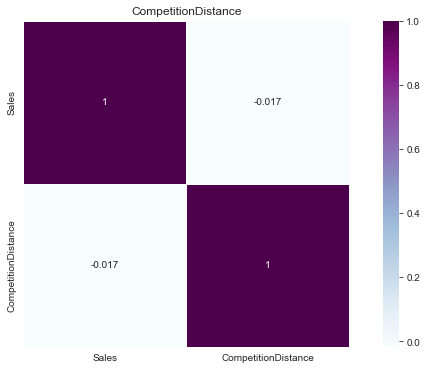

In [47]:
columns = ['Sales', 'CompetitionDistance']
plot.heatmap(df[columns], 'CompetitionDistance') 

When the competition distance become smaller, the number of Sales and Customers become higher. This is may be compititors locate themselves to the potential customers area, such as Cities. Therefore, compitition distance have a positive impact on Sales.

##### How does the opening or reopening of new competitors affect stores?

<Figure size 720x504 with 0 Axes>

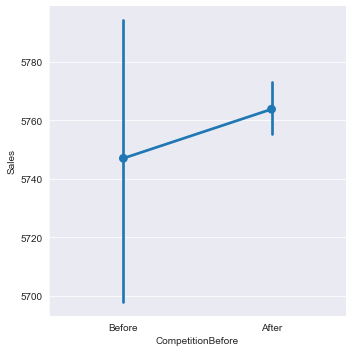

In [48]:
has_open_competition_df = df[df['CompetitionOpenSinceMonth'].notnull()]

sales_before_competition_open = has_open_competition_df[(has_open_competition_df["Year"] < has_open_competition_df["CompetitionOpenSinceYear"]) & (has_open_competition_df["Month"] < has_open_competition_df["CompetitionOpenSinceMonth"]) ]

sales_after_competition_open = has_open_competition_df[(has_open_competition_df["Year"] >= has_open_competition_df["CompetitionOpenSinceYear"]) & (has_open_competition_df["Month"] >= has_open_competition_df["CompetitionOpenSinceMonth"])]

sales_before_competition_open["CompetitionBefore"]="Before"
sales_after_competition_open["CompetitionBefore"]="After"

competition_sales_data=pd.concat([sales_before_competition_open,sales_after_competition_open])

plt.figure(figsize=(10, 7))
sns.factorplot(data = competition_sales_data, x ="CompetitionBefore", y = "Sales", sharex=False)

##### Save the Training and Testing Datasets which are merged with Store dataset

In [84]:
# Sortout Date in both training and testing dataset

train_df.sort_values(["Store","Date"], ignore_index=True, inplace=True)
test_df.sort_values(["Store","Date"], ignore_index=True, inplace=True)

for dataset in (train_df, test_df):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['Day'] = dataset.Date.dt.day
    dataset['Month'] = dataset.Date.dt.month
    dataset['Year'] = dataset.Date.dt.year
    dataset['DayOfYear'] = dataset.Date.dt.dayofyear
    dataset['WeekOfYear'] = dataset.Date.dt.weekofyear
    # dataset.set_index('Date', inplace=True)

In [88]:
file_handler.save_csv(train_df, '../data/cleaned_train.csv')
file_handler.save_csv(test_df, '../data/cleaned_test.csv') 

2022-05-26 17:08:39,299 — FileHandler — INFO — file saved as csv
2022-05-26 17:08:39,757 — FileHandler — INFO — file saved as csv
